In [1]:
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import fitting
from sunkit_spex.models.physical.albedo import Albedo
from sunkit_spex.models.physical.nonthermal import ThickTarget
from sunkit_spex.plotting.plotter import plot_fit_results
from sunkit_spex.models.physical.thermal import ThermalEmission
from sunkit_spex.models.scaling import InverseSquareFluxScaling
from sunkit_spex.models.instrument_response import MatrixModel
from sunkit_spex.spectrum.spectrum import SpectralAxis
from sunkit_spex.extern.stix import STIXLoader

/home/jmitchell/anaconda3/envs/sunkit-spex-dev/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dir = '../../data/240319/'
spec = STIXLoader(spectrum_file=dir+'stx_spectrum_2409308969_with_bkg.fits',srm_file=dir+'stx_srm_2409308969_with_bkg.fits')

spec

{'photon_channel_bins': array([[  3.927,   4.   ],
       [  4.   ,   4.073],
       [  4.073,   4.219],
       ...,
       [149.489, 149.635],
       [149.635, 149.781],
       [149.781, 149.927]]), 'photon_channel_mids': array([  3.9635,   4.0365,   4.146 , ..., 149.562 , 149.708 , 149.854 ]), 'photon_channel_binning': array([0.073, 0.073, 0.146, ..., 0.146, 0.146, 0.146]), 'count_channel_bins': array([[  4.,   5.],
       [  5.,   6.],
       [  6.,   7.],
       [  7.,   8.],
       [  8.,   9.],
       [  9.,  10.],
       [ 10.,  11.],
       [ 11.,  12.],
       [ 12.,  13.],
       [ 13.,  14.],
       [ 14.,  15.],
       [ 15.,  16.],
       [ 16.,  18.],
       [ 18.,  20.],
       [ 20.,  22.],
       [ 22.,  25.],
       [ 25.,  28.],
       [ 28.,  32.],
       [ 32.,  36.],
       [ 36.,  40.],
       [ 40.,  45.],
       [ 45.,  50.],
       [ 50.,  56.],
       [ 56.,  63.],
       [ 63.,  70.],
       [ 70.,  76.],
       [ 76.,  84.],
       [ 84., 100.]], dtype=floa

In [18]:
start = "2024-09-30T23:47:30"
end = "2024-09-30T23:47:35"

spec.start_event_time=start
spec.end_event_time=end


fig = plt.figure(figsize=(9,6))
spec.lightcurve(energy_ranges=[[4,10], [10,30], [25,50]])
plt.show()

/home/jmitchell/software/sunkit-spex-dev/sunkit_spex/extern/stix.py:507: UserWarning: 
do not update event times to (2024-09-30T23:47:30.000, 2024-10-01T22:23:52.774): covers attenuator state change. Don't trust this fit!
 Note: This error will appear if doing spectral fitting with multiple spectra and the selected event times are correct (this is because the _update_time funtion which initiates _update_srm runs for every event start/end time setting). In that case, ignore the warning.
  warnings.warn(
/home/jmitchell/anaconda3/envs/sunkit-spex-dev/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jmitchell/anaconda3/envs/sunkit-spex-dev/lib/python3.12/site-packages/numpy/_core/_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


IndexError: index 0 is out of bounds for axis 0 with size 0

In [4]:
photon_channel_bins = spec['photon_channel_bins']

count_channel_bins = spec['count_channel_bins']

indices_fit = np.where( (count_channel_bins[:,1] >= 4.0)  & (count_channel_bins[:,1] <= 55.0) )[0]

counts = (spec['count_rate'][indices_fit] *u.ct *u.keV**-1 *u.s**-1) 
counts_err = (spec['count_rate_error'][indices_fit]*u.ct*u.keV**-1 *u.s**-1) 
weights_c = 1/counts_err

srm = spec['srm'][:,indices_fit]

ph_energies = np.concatenate([photon_channel_bins[:,0], photon_channel_bins[:,1][-1:]]) * u.keV
count_energies = np.concatenate([count_channel_bins[indices_fit,0], count_channel_bins[indices_fit,1][-1:]]) * u.keV


In [5]:
srm_model = MatrixModel(
    matrix=srm, input_axis=SpectralAxis(ph_energies), output_axis=SpectralAxis(count_energies), c=1 * u.ct *u.cm**2 * u.ph**-1, 
    _input_units={"x": u.ph *u.keV**-1 *u.s**-1 * u.cm**-2}, _output_units={"y": u.ct* u.keV**-1 * u.s**-1}
)

In [6]:
distance = InverseSquareFluxScaling(1*u.AU)
f_vth = ThermalEmission()
thick = ThickTarget(break_energy=1500*u.keV,low_e_cutoff=10*u.keV)
albedo = Albedo(energy_edges=ph_energies, theta=36.68*u.deg)

ph_model_4fit = (((f_vth + thick) * distance ) | albedo)  | srm_model


In [7]:

ph_model_4fit.temperature_0.fixed = False
ph_model_4fit.emission_measure_0.fixed = False

ph_model_4fit.break_energy_1.fixed= True
ph_model_4fit.low_e_cutoff_1.fixed = False
ph_model_4fit.q_1.fixed = False
ph_model_4fit.total_eflux_1.fixed = False


In [8]:
pfit = fitting.TRFLSQFitter()
new_model = pfit(ph_model_4fit,ph_energies, counts.value,weights=weights_c.value,maxiter=100000)



/home/jmitchell/software/sunkit-spex-dev/sunkit_spex/models/physical/thermal.py:1289: UserWarning: Some input energy values outside valid range of 1.0002920302956426--10.34753795157738 keV. Flux will be zero outside this range.
  warnings.warn(message)


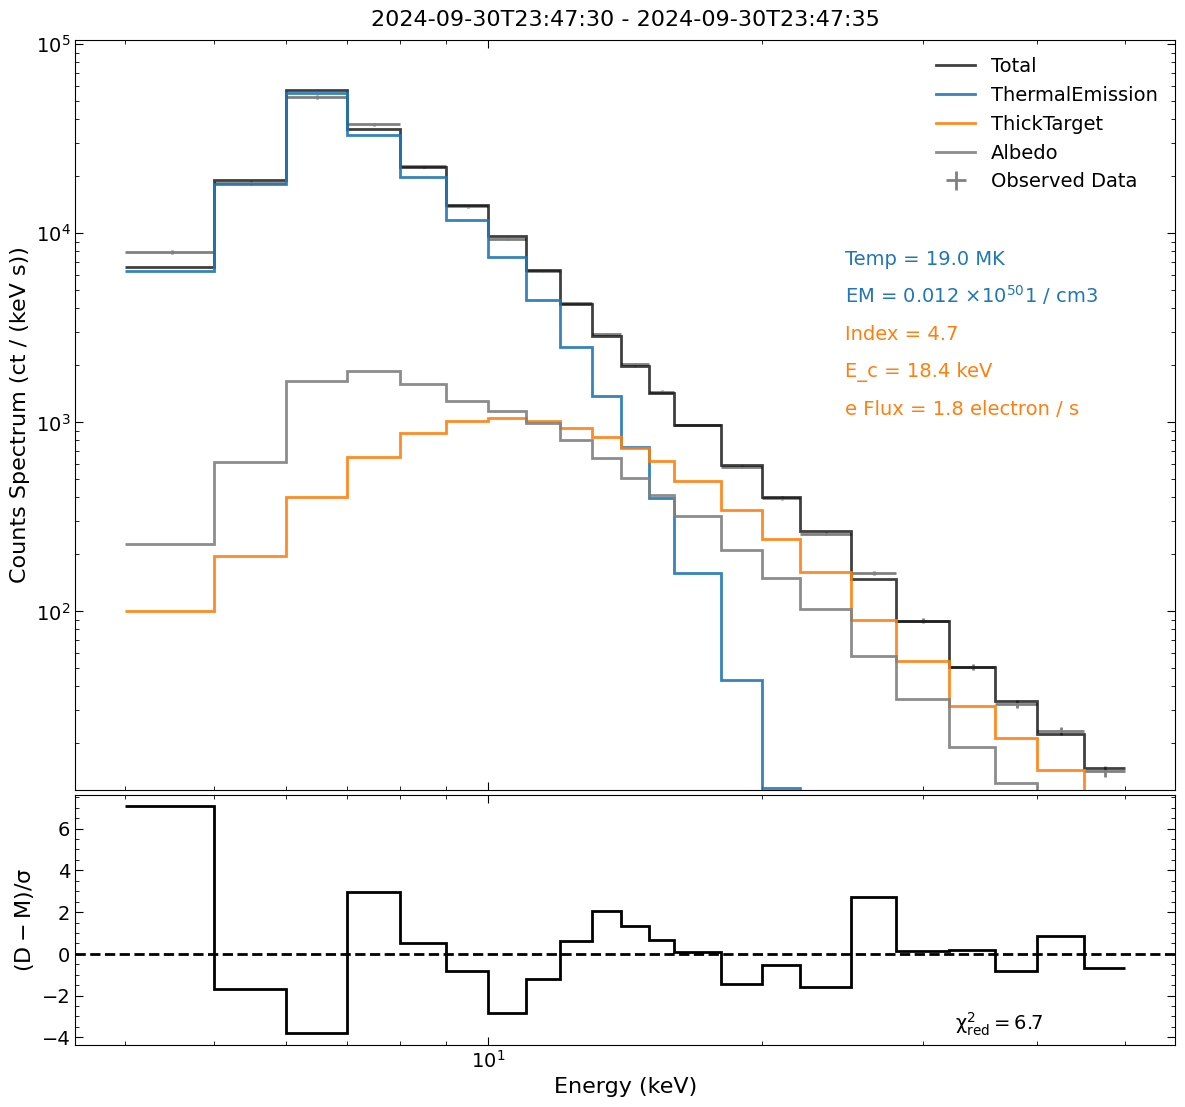

In [9]:
save_name = 'Sunkit-Spex_output.pdf'
fit_times = f'{start} - {end}'
plot_fit_results(count_energies,ph_energies,counts,counts_err, new_model,save_name,fit_times)